  SIMULATEUR DU MÉCANISME DE KELLY
  Avec arrivées/départs dynamiques (Processus de Poisson)

⚙️  Configuration:
   C: 100
   delta: 1e-06
   lambda_price: 1.0
   alpha: 1.0
   lambda_arr: 0.5
   lambda_dep: 0.3
   eta: 0.1
   policy: BR
🚀 Démarrage de la simulation (BR)
   Temps max: 50, dt: 0.1
   λ_arr: 0.5, λ_dep: 0.3
------------------------------------------------------------
✅ Simulation terminée!
   Total événements: 58
   Points enregistrés: 501
------------------------------------------------------------

  GÉNÉRATION DES VISUALISATIONS CORRIGÉES

📊 Graphiques comparatifs (Focus sur les 8 joueurs les plus récents/actifs)


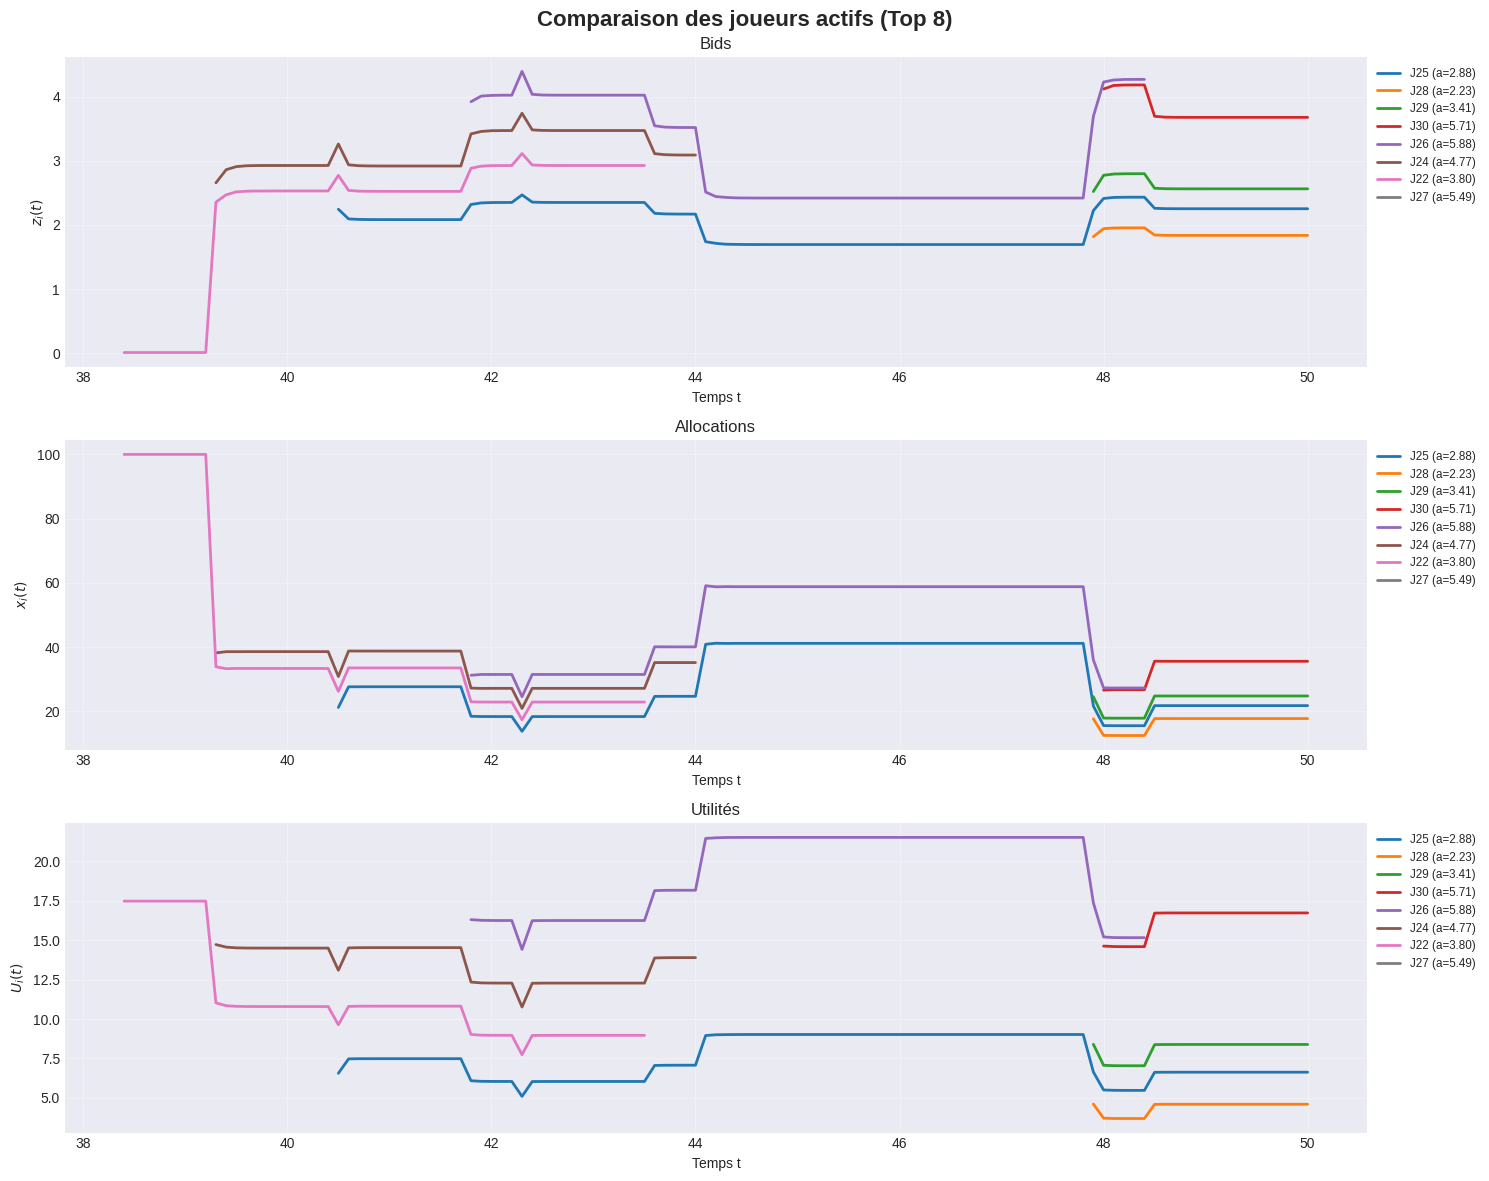


📊 Vue Globale : Distribution de la Capacité (Stacked Area)


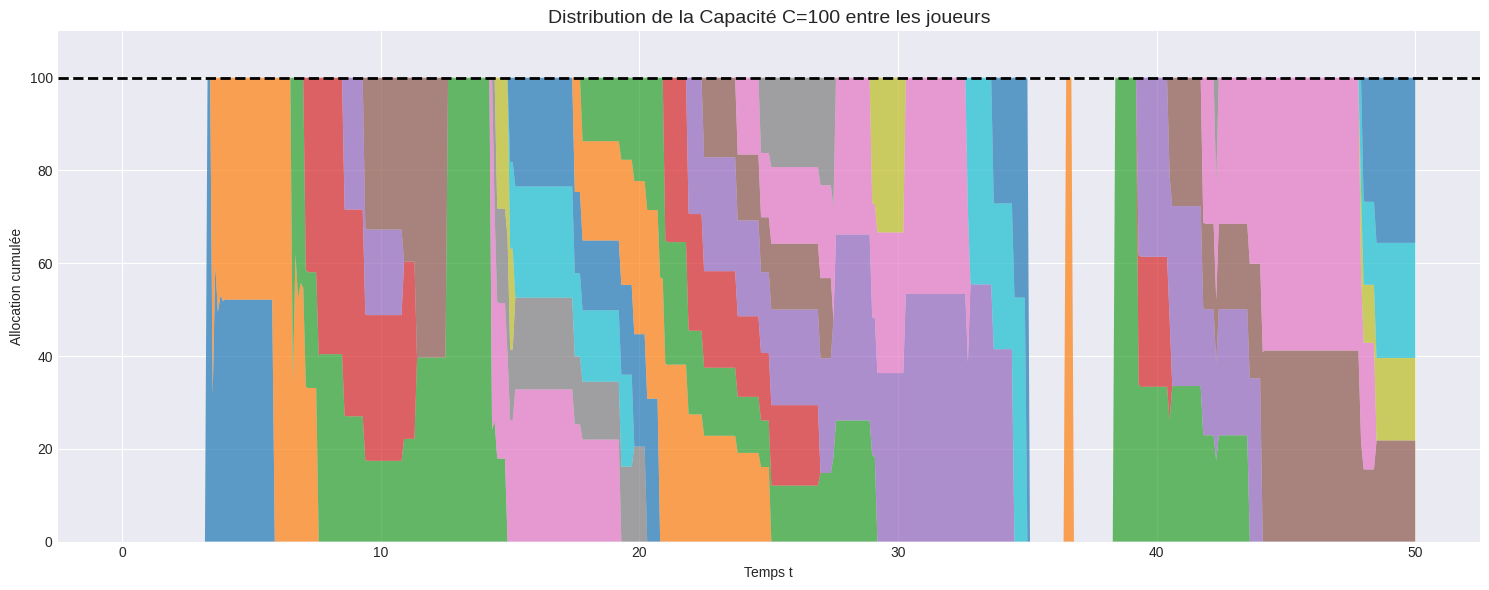


📊 Métriques globales du système


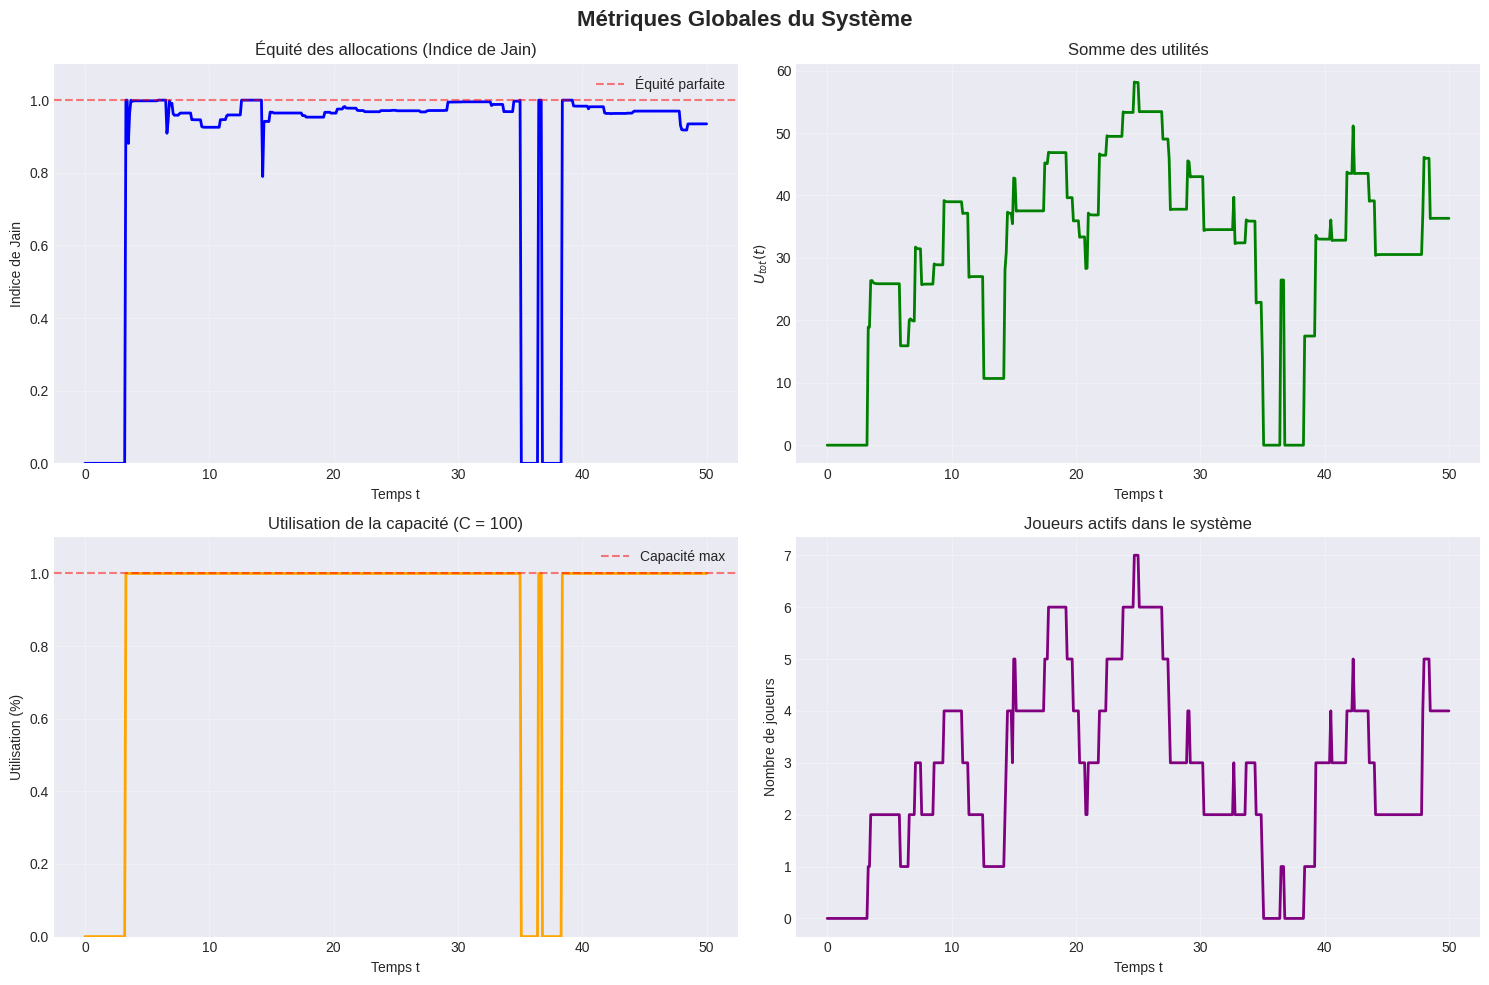


  ✅ SIMULATION ET VISUALISATIONS TERMINÉES

🔄 Pour comparer Best Response vs Gradient Descent:
   1. Changez 'policy': 'GD' dans config
   2. Relancez le code


In [ ]:
"""
Simulateur du Mécanisme de Kelly avec Arrivées/Départs Dynamiques
Auteur: Simulation complète pour TP
Usage: Google Colab / Jupyter Notebook
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Configuration matplotlib pour de beaux graphiques
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

@dataclass
class Player:
    """Représente un joueur dans le système"""
    id: int
    a: float  # Paramètre de valeur
    z: float  # Bid actuel
    arrival_time: float
    departure_time: float

class KellyMechanism:
    """Simulateur du mécanisme de Kelly avec utilisateurs dynamiques"""

    def __init__(self, C=100, delta=0.01, lambda_price=1.0, alpha=1.0,
                 lambda_arr=0.5, lambda_dep=0.3, eta=0.1, policy='BR'):
        """
        Paramètres:
        -----------
        C : float - Capacité totale
        delta : float - Petite constante pour éviter division par zéro
        lambda_price : float - Prix de la ressource
        alpha : float - Paramètre α-fair (1 = Kelly)
        lambda_arr : float - Taux d'arrivée (Poisson)
        lambda_dep : float - Taux de départ (Poisson)
        eta : float - Pas du gradient descent
        policy : str - 'BR' pour Best Response, 'GD' pour Gradient Descent
        """
        self.C = C
        self.delta = delta
        self.lambda_price = lambda_price
        self.alpha = alpha
        self.lambda_arr = lambda_arr
        self.lambda_dep = lambda_dep
        self.eta = eta
        self.policy = policy

        # État du système
        self.players: List[Player] = []
        self.time = 0.0
        self.next_player_id = 0

        # Historique
        self.history = []
        self.events = []

    def compute_allocation(self, z_i: float) -> float:
        """Calcule l'allocation pour un bid donné"""
        total_bid = sum(p.z for p in self.players) + self.delta
        return (self.C * z_i) / total_bid

    def compute_utility(self, a: float, x: float, z: float) -> float:
        """Calcule l'utilité α-fair"""
        x = max(x, 1e-10)  # Éviter log(0)

        if abs(self.alpha - 1.0) < 1e-6:
            # Cas Kelly (α = 1)
            return a * np.log(x) - self.lambda_price * z
        else:
            # Cas général α ≠ 1
            term = np.power(x, 1 - self.alpha)
            return a * (term - 1) / (1 - self.alpha) - self.lambda_price * z

    def utility_derivative(self, a: float, x: float) -> float:
        """Calcule U'_i(x_i)"""
        x = max(x, 1e-10)

        if abs(self.alpha - 1.0) < 1e-6:
            return a / x
        else:
            return a * np.power(x, -self.alpha)

    def compute_best_response(self, player: Player) -> float:
        """Calcule le Best Response pour un joueur"""
        # Somme des bids des autres joueurs
        s = sum(p.z for p in self.players if p.id != player.id)

        if s < 1e-10:
            # Joueur seul dans le système
            return 0.01

        a = player.a
        lam = self.lambda_price

        # Résolution de l'équation quadratique
        # z^2 + s*z - (a*s/λ) = 0
        discriminant = s * s + 4 * a * s / lam

        if discriminant < 0:
            return 0.01

        z_opt = (-s + np.sqrt(discriminant)) / 2
        return max(0.01, z_opt)

    def compute_gradient_step(self, player: Player) -> float:
        """Calcule le nouveau bid par gradient descent"""
        total_bid = sum(p.z for p in self.players) + self.delta
        x_i = self.compute_allocation(player.z)

        # Calcul de ∂x_i/∂z_i
        dx_dz = self.C * (total_bid - player.z) / (total_bid ** 2)

        # Gradient
        u_prime = self.utility_derivative(player.a, x_i)
        gradient = u_prime * dx_dz - self.lambda_price

        # Mise à jour
        new_z = player.z + self.eta * gradient
        return max(0.01, new_z)

    def update_bids(self):
        """Met à jour les bids de tous les joueurs"""
        if not self.players:
            return

        new_bids = []
        for player in self.players:
            if self.policy == 'BR':
                new_z = self.compute_best_response(player)
            else:  # GD
                new_z = self.compute_gradient_step(player)
            new_bids.append(new_z)

        # Mise à jour simultanée
        for player, new_z in zip(self.players, new_bids):
            player.z = new_z

    def add_player(self):
        """Ajoute un nouveau joueur au système"""
        a_i = np.random.uniform(2, 6)  # a_i ~ Uniform[2, 6]
        departure_time = self.time + np.random.exponential(1 / self.lambda_dep)

        player = Player(
            id=self.next_player_id,
            a=a_i,
            z=1.0,  # Initialisation
            arrival_time=self.time,
            departure_time=departure_time
        )

        self.players.append(player)
        self.events.append({
            'time': self.time,
            'pid': player.id,
            'a_i': a_i,
            'type': 'arrival'
        })

        self.next_player_id += 1

    def remove_player(self, player_id: int):
        """Retire un joueur du système"""
        player = next((p for p in self.players if p.id == player_id), None)
        if player:
            self.players = [p for p in self.players if p.id != player_id]
            self.events.append({
                'time': self.time,
                'pid': player_id,
                'a_i': player.a,
                'type': 'departure'
            })

    def record_state(self):
        """Enregistre l'état actuel du système"""
        if not self.players:
            self.history.append({
                'time': self.time,
                'players': [],
                'num_players': 0
            })
            return

        players_data = []
        for p in self.players:
            x = self.compute_allocation(p.z)
            u = self.compute_utility(p.a, x, p.z)
            players_data.append({
                'id': p.id,
                'a': p.a,
                'z': p.z,
                'x': x,
                'u': u
            })

        # Métriques globales
        allocations = [pd['x'] for pd in players_data]
        utilities = [pd['u'] for pd in players_data]

        sum_x = sum(allocations)
        sum_x2 = sum(x**2 for x in allocations)

        # Indice de Jain
        n = len(self.players)
        jain = (sum_x ** 2) / (n * sum_x2) if sum_x2 > 0 else 0

        self.history.append({
            'time': self.time,
            'players': players_data,
            'num_players': n,
            'jain': jain,
            'total_utility': sum(utilities),
            'capacity_usage': sum_x / self.C
        })

    def simulate(self, max_time=50, dt=0.1):
        """
        Simule le système avec arrivées/départs dynamiques

        Paramètres:
        -----------
        max_time : float - Temps maximal de simulation
        dt : float - Pas de temps pour l'enregistrement
        """
        # Initialisation
        next_arrival = np.random.exponential(1 / self.lambda_arr)
        recording_times = np.arange(0, max_time + dt, dt)
        recording_idx = 0

        print(f"🚀 Démarrage de la simulation ({self.policy})")
        print(f"   Temps max: {max_time}, dt: {dt}")
        print(f"   λ_arr: {self.lambda_arr}, λ_dep: {self.lambda_dep}")
        print("-" * 60)

        while self.time < max_time:
            # Temps du prochain enregistrement
            next_recording = recording_times[recording_idx] if recording_idx < len(recording_times) else max_time + 1

            # Événements à venir
            events = [('arrival', next_arrival)]
            for p in self.players:
                if p.departure_time > self.time:
                    events.append(('departure', p.departure_time, p.id))

            # Trier par temps
            events.sort(key=lambda e: e[1])

            # Prochain événement
            if events and events[0][1] < next_recording:
                event_type = events[0][0]
                event_time = events[0][1]
                self.time = event_time

                if event_type == 'arrival':
                    self.add_player()
                    next_arrival = self.time + np.random.exponential(1 / self.lambda_arr)
                else:  # departure
                    player_id = events[0][2]
                    self.remove_player(player_id)

                # Mise à jour des bids après l'événement
                self.update_bids()
            else:
                # Avancer jusqu'au prochain enregistrement
                self.time = next_recording
                self.update_bids()
                self.record_state()
                recording_idx += 1

        print(f"✅ Simulation terminée!")
        print(f"   Total événements: {len(self.events)}")
        print(f"   Points enregistrés: {len(self.history)}")
        print("-" * 60)

def plot_individual_players(sim: KellyMechanism, max_players=6):
    """Trace les graphiques individuels pour chaque joueur"""

    # Extraire les données par joueur
    player_data = {}
    for snapshot in sim.history:
        for p in snapshot['players']:
            pid = p['id']
            if pid not in player_data:
                player_data[pid] = {'times': [], 'bids': [], 'allocs': [], 'utils': [], 'a': p['a']}
            player_data[pid]['times'].append(snapshot['time'])
            player_data[pid]['bids'].append(p['z'])
            player_data[pid]['allocs'].append(p['x'])
            player_data[pid]['utils'].append(p['u'])

    # Limiter aux max_players premiers
    player_ids = sorted(player_data.keys())[:max_players]

    if not player_ids:
        print("⚠️ Aucun joueur à afficher")
        return

    print(f"\n📊 Graphiques individuels pour {len(player_ids)} joueurs")

    for pid in player_ids:
        data = player_data[pid]

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f'Joueur {pid} (a = {data["a"]:.2f})', fontsize=14, fontweight='bold')

        # Bid
        axes[0].plot(data['times'], data['bids'], 'b-', linewidth=2)
        axes[0].set_xlabel('Temps t')
        axes[0].set_ylabel('Bid $z_i(t)$')
        axes[0].set_title('Évolution du bid')
        axes[0].grid(True, alpha=0.3)

        # Allocation
        axes[1].plot(data['times'], data['allocs'], 'g-', linewidth=2)
        axes[1].set_xlabel('Temps t')
        axes[1].set_ylabel('Allocation $x_i(t)$')
        axes[1].set_title('Évolution de l\'allocation')
        axes[1].grid(True, alpha=0.3)

        # Utilité
        axes[2].plot(data['times'], data['utils'], 'orange', linewidth=2)
        axes[2].set_xlabel('Temps t')
        axes[2].set_ylabel('Utilité $U_i(t)$')
        axes[2].set_title('Évolution de l\'utilité')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

def plot_comparative(sim: KellyMechanism, max_players=6):
    """
    Trace les graphiques comparatifs en sélectionnant les joueurs les plus pertinents
    (ceux qui sont restés le plus longtemps ou qui sont là à la fin).
    """
    # 1. Extraction et nettoyage des données
    player_data = {}

    # On parcourt tout l'historique
    for snapshot in sim.history:
        t = snapshot['time']
        for p in snapshot['players']:
            pid = p['id']
            if pid not in player_data:
                player_data[pid] = {'times': [], 'bids': [], 'allocs': [], 'utils': [], 'a': p['a']}

            player_data[pid]['times'].append(t)
            player_data[pid]['bids'].append(p['z'])
            player_data[pid]['allocs'].append(p['x'])
            player_data[pid]['utils'].append(p['u'])

    # 2. Stratégie de sélection intelligente :
    # On trie les joueurs par "Dernier temps d'activité" (pour voir les survivants)
    # Et en cas d'égalité, par durée de vie.
    all_ids = sorted(
        player_data.keys(),
        key=lambda pid: (player_data[pid]['times'][-1], len(player_data[pid]['times'])),
        reverse=True
    )

    # On garde les X meilleurs
    player_ids = all_ids[:max_players]

    if not player_ids:
        print("⚠️ Aucun joueur à afficher")
        return

    print(f"\n📊 Graphiques comparatifs (Focus sur les {len(player_ids)} joueurs les plus récents/actifs)")

    # Couleurs
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, max_players)))

    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'Comparaison des joueurs actifs (Top {len(player_ids)})', fontsize=16, fontweight='bold')

    # Boucle d'affichage
    for i, pid in enumerate(player_ids):
        data = player_data[pid]

        # Astuce : On ne relie pas les points si l'écart de temps est trop grand (départ/revenu)
        # Mais ici, on affiche juste les segments existants.
        lbl = f'J{pid} (a={data["a"]:.2f})'

        axes[0].plot(data['times'], data['bids'], color=colors[i % 10], linewidth=2, label=lbl)
        axes[1].plot(data['times'], data['allocs'], color=colors[i % 10], linewidth=2, label=lbl)
        axes[2].plot(data['times'], data['utils'], color=colors[i % 10], linewidth=2, label=lbl)

    # Mise en forme
    for ax, title, ylabel in zip(axes, ['Bids', 'Allocations', 'Utilités'], ['$z_i(t)$', '$x_i(t)$', '$U_i(t)$']):
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Temps t')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small') # Légende sur le côté

    plt.tight_layout()
    plt.show()

def plot_global_metrics(sim: KellyMechanism):
    """Trace les métriques globales du système"""

    times = [h['time'] for h in sim.history]
    jains = [h.get('jain', 0) for h in sim.history]
    total_utils = [h.get('total_utility', 0) for h in sim.history]
    cap_usage = [h.get('capacity_usage', 0) for h in sim.history]
    num_players = [h['num_players'] for h in sim.history]

    print(f"\n📊 Métriques globales du système")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Métriques Globales du Système', fontsize=16, fontweight='bold')

    # Indice de Jain
    axes[0, 0].plot(times, jains, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Temps t')
    axes[0, 0].set_ylabel('Indice de Jain')
    axes[0, 0].set_title('Équité des allocations (Indice de Jain)')
    axes[0, 0].set_ylim([0, 1.1])
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Équité parfaite')
    axes[0, 0].legend()

    # Somme des utilités
    axes[0, 1].plot(times, total_utils, 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Temps t')
    axes[0, 1].set_ylabel('$U_{tot}(t)$')
    axes[0, 1].set_title('Somme des utilités')
    axes[0, 1].grid(True, alpha=0.3)

    # Utilisation de la capacité
    axes[1, 0].plot(times, cap_usage, 'orange', linewidth=2)
    axes[1, 0].set_xlabel('Temps t')
    axes[1, 0].set_ylabel('Utilisation (%)')
    axes[1, 0].set_title(f'Utilisation de la capacité (C = {sim.C})')
    axes[1, 0].set_ylim([0, 1.1])
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Capacité max')
    axes[1, 0].legend()

    # Nombre de joueurs
    axes[1, 1].plot(times, num_players, 'purple', linewidth=2)
    axes[1, 1].set_xlabel('Temps t')
    axes[1, 1].set_ylabel('Nombre de joueurs')
    axes[1, 1].set_title('Joueurs actifs dans le système')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def display_events_table(sim: KellyMechanism, max_rows=50):
    """Affiche l'historique des événements sous forme de tableau"""

    if not sim.events:
        print("⚠️ Aucun événement enregistré")
        return

    print(f"\n📋 Historique des événements (derniers {min(max_rows, len(sim.events))} sur {len(sim.events)})")

    df = pd.DataFrame(sim.events)
    df['time'] = df['time'].round(3)
    df['a_i'] = df['a_i'].round(3)

    # Afficher les derniers événements
    print(df.tail(max_rows).to_string(index=False))

    # Statistiques
    arrivals = len(df[df['type'] == 'arrival'])
    departures = len(df[df['type'] == 'departure'])

    print(f"\n📊 Statistiques:")
    print(f"   Total arrivées: {arrivals}")
    print(f"   Total départs: {departures}")
    print(f"   Joueurs restants: {arrivals - departures}")
def plot_stacked_allocation(sim):
    """
    Affiche l'allocation sous forme de graphique empilé (Stacked Area Chart).
    C'est la preuve visuelle que Somme(x) = C.
    """
    # Préparation des données matricielles
    times = [h['time'] for h in sim.history]
    all_pids = sorted(list(set(p['id'] for h in sim.history for p in h['players'])))

    # Matrice : une ligne par joueur, une colonne par pas de temps
    # On remplit avec 0 si le joueur n'est pas là
    alloc_matrix = []
    labels = []

    for pid in all_pids:
        player_allocs = []
        is_ever_active = False
        for h in sim.history:
            # Trouver l'alloc du joueur à ce temps t, sinon 0
            val = next((p['x'] for p in h['players'] if p['id'] == pid), 0.0)
            player_allocs.append(val)
            if val > 0: is_ever_active = True

        # On ne garde que les joueurs qui ont existé au moins une fois
        if is_ever_active:
            alloc_matrix.append(player_allocs)
            labels.append(f"J{pid}")

    if not alloc_matrix:
        return

    print(f"\n📊 Vue Globale : Distribution de la Capacité (Stacked Area)")

    fig, ax = plt.subplots(figsize=(15, 6))

    # Création du graphique empilé
    ax.stackplot(times, alloc_matrix, labels=labels, alpha=0.7)

    ax.set_title(f"Distribution de la Capacité C={sim.C} entre les joueurs", fontsize=14)
    ax.set_xlabel("Temps t")
    ax.set_ylabel("Allocation cumulée")
    ax.set_ylim(0, sim.C * 1.1)
    ax.axhline(y=sim.C, color='black', linestyle='--', linewidth=2, label="Capacité Max")

    # Légende intelligente (seulement si pas trop de joueurs)
    if len(labels) < 15:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()
# ============================================================================
# EXÉCUTION PRINCIPALE
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("  SIMULATEUR DU MÉCANISME DE KELLY")
    print("  Avec arrivées/départs dynamiques (Processus de Poisson)")
    print("="*60)

    # Configuration de la simulation
    config = {
        'C': 100,              # Capacité
        'delta': 0.000001,         # Constante
        'lambda_price': 1.0,   # Prix
        'alpha': 1.0,          # α-fair (1 = Kelly)
        'lambda_arr': 0.5,     # Taux d'arrivée
        'lambda_dep': 0.3,     # Taux de départ
        'eta': 0.1,            # Pas gradient
        'policy': 'BR'         # 'BR' ou 'GD'
    }

    print("\n⚙️  Configuration:")
    for key, value in config.items():
        print(f"   {key}: {value}")

    # Créer et exécuter la simulation
    sim = KellyMechanism(**config)
    sim.simulate(max_time=50, dt=0.1)

  # Générer tous les graphiques
    print("\n" + "="*60)
    print("  GÉNÉRATION DES VISUALISATIONS CORRIGÉES")
    print("="*60)

    # 1. Graphiques individuels (inchangé ou votre version préférée)
    # plot_individual_players(sim, max_players=4)

    # 2. Graphiques comparatifs INTELLIGENTS (les survivants)
    plot_comparative(sim, max_players=8)

    # 3. La preuve de cohérence (Graphique empilé)
    plot_stacked_allocation(sim)

    # 4. Métriques globales
    plot_global_metrics(sim)

    print("\n" + "="*60)
    print("  ✅ SIMULATION ET VISUALISATIONS TERMINÉES")
    print("="*60)

    # Optionnel: Comparer BR vs GD
    print("\n🔄 Pour comparer Best Response vs Gradient Descent:")
    print("   1. Changez 'policy': 'GD' dans config")
    print("   2. Relancez le code")

In [ ]:
def display_detailed_comparison(sim, start_time=0, end_time=None):
    """
    Génère un tableau complet et coloré pour comparer tous les joueurs
    instant par instant.

    Paramètres :
    - start_time, end_time : Pour zoomer sur une période (ex: t=8 à t=10)
    """

    if end_time is None:
        end_time = sim.time

    # 1. Extraction des données
    rows = []
    for snap in sim.history:
        t = snap['time']

        # Filtre temporel
        if not (start_time <= t <= end_time):
            continue

        players = snap['players']
        total_bid = sum(p['z'] for p in players) + sim.delta

        # Si aucun joueur, on ajoute une ligne vide pour info
        if not players:
            rows.append({
                'Temps': t, 'ID': '-', 'Type': 'VIDE',
                'a_i': 0, 'Bid (z)': 0, 'Part du Bid (%)': 0,
                'Alloc (x)': 0, 'Utilité (U)': 0, 'Check Math': 0
            })
            continue

        for p in players:
            # Vérification mathématique : Kelly Theoretical
            # x_theorique = (z / Total_Z) * C
            x_theo = (p['z'] / total_bid) * sim.C
            ecart = abs(p['x'] - x_theo)

            rows.append({
                'Temps': t,
                'ID': p['id'],
                'a_i': p['a'],
                'Bid (z)': p['z'],
                'Part du Bid (%)': (p['z'] / total_bid) * 100,
                'Alloc (x)': p['x'],
                'Utilité (U)': p['u'],
                'Check Math': '✅' if ecart < 0.01 else f'❌ ({ecart:.2f})'
            })

    # 2. Création du DataFrame
    df = pd.DataFrame(rows)

    if df.empty:
        print("⚠️ Aucune donnée sur cette période.")
        return

    # 3. Mise en forme et "Styling" pour la lisibilité
    # On arrondit tout
    df = df.round(3)

    # Configuration de l'affichage interactif avec couleurs
    # - Bids : Barres bleues
    # - Allocations : Dégradé vert
    # - Utilité : Dégradé orange
    styled_df = (df.style
        .format("{:.3f}", subset=['Temps', 'a_i', 'Bid (z)', 'Alloc (x)', 'Utilité (U)', 'Part du Bid (%)'])
        .background_gradient(subset=['Alloc (x)'], cmap='Greens')
        .background_gradient(subset=['Utilité (U)'], cmap='Oranges')
        .bar(subset=['Bid (z)'], color='#5fba7d', vmax=df['Bid (z)'].max())
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('background-color', '#f0f0f0')]}
        ])
    )

    print(f"\n📋 DÉTAILS COMPLETS DU JEU (t = {start_time} à {end_time})")
    print("="*60)

    # Affichage forcé de toutes les lignes (pour Jupyter/Colab)
    try:
        from IPython.display import display
        display(styled_df)
    except:
        print(df.to_string()) # Fallback pour console standard

# ==========================================
# EXEMPLE D'UTILISATION
# ==========================================

# 1. Pour voir le moment précis où tout change (ex: autour de t=8.3)
display_detailed_comparison(sim, start_time=8.0, end_time=9.0)

# 2. Pour voir la fin de la simulation
display_detailed_comparison(sim, start_time=45.0, end_time=50.0)


📋 DÉTAILS COMPLETS DU JEU (t = 8.0 à 9.0)


,Temps,ID,a_i,Bid (z),Part du Bid (%),Alloc (x),Utilité (U),Check Math
0,8.000,2,2.323,1.384,40.412,40.412,7.208,✅
1,8.000,3,5.048,2.041,59.587,59.587,18.594,✅
2,8.100,2,2.323,1.384,40.416,40.416,7.208,✅
3,8.100,3,5.048,2.041,59.584,59.584,18.594,✅
4,8.200,2,2.323,1.384,40.416,40.416,7.208,✅
5,8.200,3,5.048,2.040,59.584,59.584,18.594,✅
6,8.300,2,2.323,1.384,40.416,40.416,7.208,✅
7,8.300,3,5.048,2.040,59.584,59.584,18.594,✅
8,8.400,2,2.323,1.384,40.416,40.416,7.208,✅
9,8.400,3,5.048,2.040,59.584,59.584,18.594,✅



📋 DÉTAILS COMPLETS DU JEU (t = 45.0 à 50.0)


,Temps,ID,a_i,Bid (z),Part du Bid (%),Alloc (x),Utilité (U),Check Math
0,45.000,25,2.881,1.695,41.186,41.186,9.019,✅
1,45.000,26,5.876,2.420,58.814,58.814,21.520,✅
2,45.100,25,2.881,1.695,41.186,41.186,9.019,✅
3,45.100,26,5.876,2.420,58.814,58.814,21.520,✅
4,45.200,25,2.881,1.695,41.186,41.186,9.019,✅
5,45.200,26,5.876,2.420,58.814,58.814,21.520,✅
6,45.300,25,2.881,1.695,41.186,41.186,9.019,✅
7,45.300,26,5.876,2.420,58.814,58.814,21.520,✅
8,45.400,25,2.881,1.695,41.186,41.186,9.019,✅
9,45.400,26,5.876,2.420,58.814,58.814,21.520,✅
